# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2024-LGElec-Day20.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

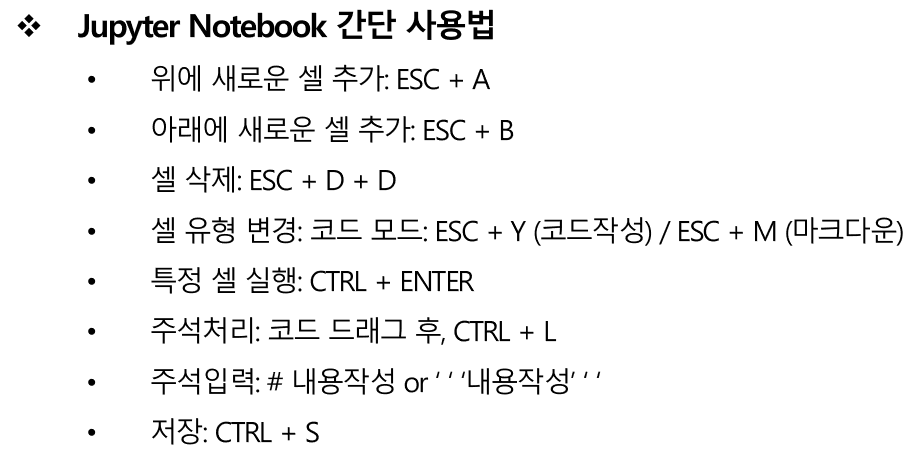

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day20/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - (2) Data Balancing (2) - Oversampling 

 - ***(3) XAI √***

## **[XAI - Image 목차]**

  - LIME

  - SHAP

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [3]:
""" 필요 패키지 설치 """
!pip install lime

You should consider upgrading via the 'C:\Users\DMQA\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
""" 필요 패키지 설치 """
!pip install shap

You should consider upgrading via the 'C:\Users\DMQA\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import cv2
import time
import json
import numpy as np
import pandas as pd


""" 이미지 전처리 패키지 """
from skimage.segmentation import mark_boundaries


""" 모델링 및 성능 산출과 관련된 패키지"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tf
from torchvision.models import vgg16, VGG16_Weights


""" XAI 패키지 """
import shap
from shap import TreeExplainer
from lime.lime_image import LimeImageExplainer


""" 시각화 패키지 """
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

c:\Users\DMQA\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **0-2. 필요 함수 사전 정의**

In [6]:
""" (1) 이미지를 정규화하는 함수 """

def normalize(image):

    ### 픽셀값이 0~255면 0~1로 우선 변환
    if image.max() > 1:
        scaled_image = image/255.

    ### 데이터 정규화
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    scaled_image = (scaled_image - mean) / std

    ### torch에 맞게 차원 변경
    torch_image = torch.tensor(scaled_image.swapaxes(-1, 1).swapaxes(2, 3)).float()
    return torch_image

## **1. 실습 데이터셋 확보**

 - 데이터: ImageNet 데이터 (일상 이미지 데이터) 

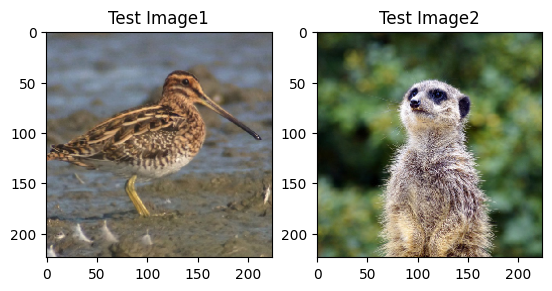

In [7]:
""" 데이터 불러오기 """

### 데이터 불러오기
X, y = shap.datasets.imagenet50()

### 시각화
test_imgs = X[[39, 41]]
plt.subplot(1, 2, 1)
plt.imshow(test_imgs[0] / 255.)
plt.title('Test Image1')

plt.subplot(1, 2, 2)
plt.imshow(test_imgs[1] / 255.) # BGR -> RGB
plt.title('Test Image2')
plt.show()

## **2. Base 모델 불러오기**

 - 학습 대신, 기존에 사전학습된 Weight를 활용

In [8]:
""" 사전학습된 모델 불러오기 """
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = vgg16(weights=VGG16_Weights.DEFAULT).to(device) ### ImageNet 데이터로 사전학습된 모델
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
""" 모델 예측값 산출 """
test_imgs_tensor = normalize(test_imgs).to(device) ### pytorch tensor로 변환
outputs = model(test_imgs_tensor) ### 예측
outputs.shape ### 2개 이미지가 1000개 Class에 대한 예측 결과

torch.Size([2, 1000])

In [10]:
""" Logit을 확률로 변환"""

### 확률로 변환
probs = F.softmax(outputs, dim=1)

### Top5 확률 확인
probs5 = probs.topk(5)
print(probs5)

torch.return_types.topk(
values=tensor([[9.9973e-01, 2.1312e-04, 5.3029e-05, 5.9301e-06, 2.1325e-07],
        [9.2088e-01, 7.8541e-02, 5.4766e-04, 1.2048e-05, 4.9332e-06]],
       device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[142, 140, 141, 139, 133],
        [299, 298, 336, 360, 356]], device='cuda:0'))


In [11]:
""" Class 정보 불러오기 """

### 경로 설정
class_dir = 'data/imagenet_class_index.json' ### 로컬 사용 시
# class_dir = '/content/2024-LGElec-Day20/data/imagenet_class_index.json' ### 로컬 사용 시

### ImageNet 이미지 데이터에 대응되는  Class 불러오기
with open(file=class_dir, mode='rt') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))] ### label의 집합

idx2label

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [12]:
""" 실제로 어떤 class로 예측했는지 확인 """

sample_idx = 0
array_prob = probs5[0][sample_idx].cpu().detach().numpy()
array_class = probs5[1][sample_idx].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,9.997277e-01,142,dowitcher
1,2.131241e-04,140,red-backed_sandpiper
2,5.302884e-05,141,redshank
3,5.930116e-06,139,ruddy_turnstone
4,2.132507e-07,133,bittern


In [13]:
""" 실제로 어떤 class로 예측했는지 확인 """

sample_idx = 1
array_prob = probs5[0][sample_idx].cpu().detach().numpy()
array_class = probs5[1][sample_idx].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,0.920884,299,meerkat
1,0.078541,298,mongoose
2,0.000548,336,marmot
3,0.000012,360,otter
4,0.000005,356,weasel


## **3. LIME**

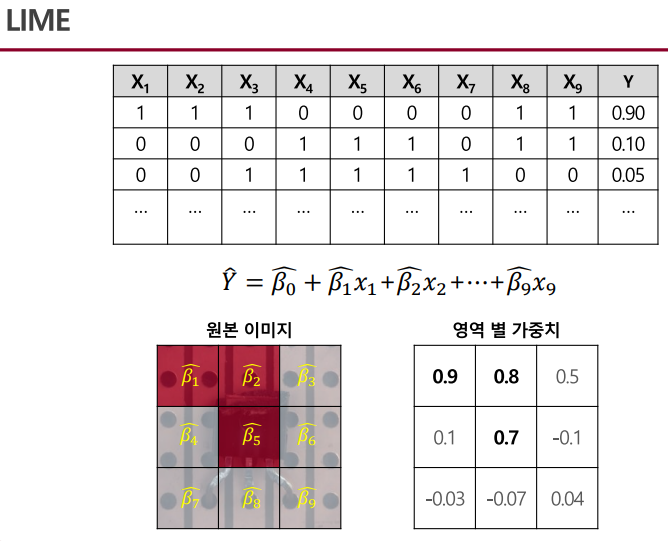

In [37]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/9-XAI5.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day20/image/9-XAI5.PNG') ### colab 사용 시

In [15]:
""" LIME 모델링에 필요한 함수 정의  """

def batch_predict(images:list):

    ### torch type으로 데이터 변환
    sample_transform = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((224,224)),
    tf.ToTensor(),
    tf.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
    ])
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch = torch.stack(tuple(sample_transform(i) for i in images), dim=0).to(device)
    
    ### 모델이 각 이미지를 예측한 확률을 반환
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy() 


In [16]:
""" 관측치 별 LIME 모델 학습 """
explainer = LimeImageExplainer()

explanation1 = explainer.explain_instance(np.array(test_imgs[0].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

explanation2 = explainer.explain_instance(np.array(test_imgs[1].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

100%|██████████| 1000/1000 [00:04<00:00, 218.74it/s]


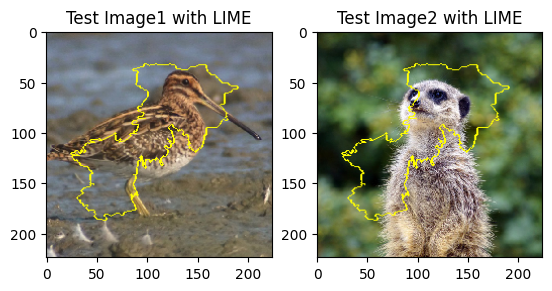

In [17]:
""" 결과 시각화 """

temp1, mask1 = explanation1.get_image_and_mask(explanation1.top_labels[0], ### 가장 높은 확률을 갖는 Class에 대한 해석
                                               positive_only=True, ### 예측확률을 높이는데 기여한 것만 표시
                                               num_features=5, ### 표시할 패치 개수
                                               hide_rest=False) ### 전체 이미지 표시 여부
img_boundry1 = mark_boundaries(temp1/255.0, mask1)

temp2, mask2 = explanation2.get_image_and_mask(explanation2.top_labels[0], 
                                               positive_only=True, 
                                               num_features=5, 
                                               hide_rest=False)
img_boundry2 = mark_boundaries(temp2/255.0, mask1)

plt.subplot(1, 2, 1)
plt.imshow(img_boundry1)
plt.title('Test Image1 with LIME')

plt.subplot(1, 2, 2)
plt.imshow(img_boundry2)
plt.title('Test Image2 with LIME')
plt.show()

## **4. SHAP**

 - Shap Value를 추정하는 방법에 따라 여러 함수 존재

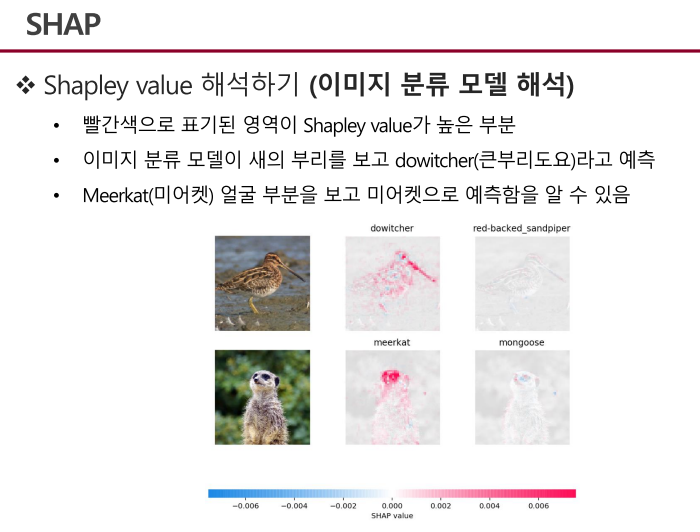

In [36]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/9-XAI6.PNG') ### 로컬 사용 시
# Image('/content/2024-LGElec-Day20/image/9-XAI6.PNG') ### colab 사용 시

#### **4-1. GradientShap**

 - 각 Feature의 Gradient에 기여한 정도에 따라 구분

In [18]:
""" Shap Value 측정 """

device = 'cuda' if torch.cuda.is_available() else 'cpu'
explainer = shap.GradientExplainer(model=(model, model.features[7]), ### Index7 Feature에 기여여부로 파악
                                   data=normalize(X).to(device)) 

shap_values_tensor, indexes = explainer.shap_values(X=normalize(test_imgs).to(device),
                                            ranked_outputs=2)
print(shap_values_tensor.shape) ### (column, channel, width, height, row)
print(indexes)

(2, 128, 112, 112, 2)
tensor([[142, 140],
        [299, 298]], device='cuda:0')


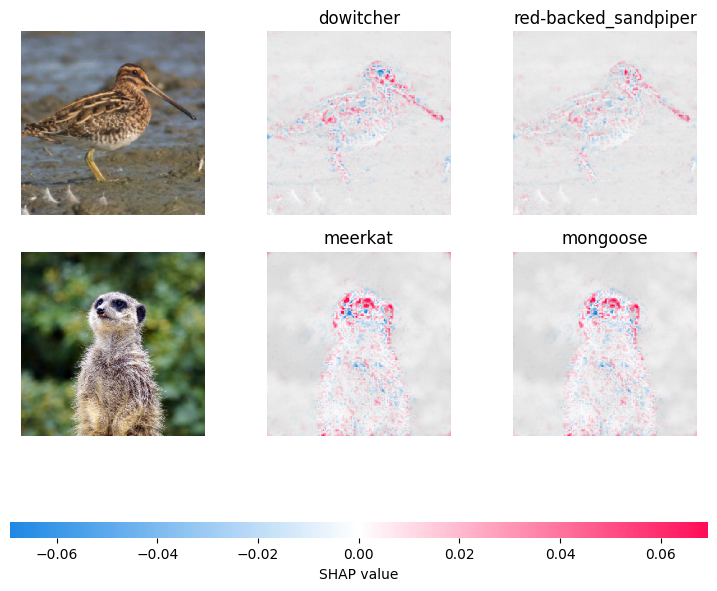

In [19]:
""" Shap Value 시각화"""

### Class명 할당
index_names = np.vectorize(lambda x: class_idx[str(x)][1])(indexes.cpu())

### Shap Value 조정
shap_values_tensor = np.swapaxes(shap_values_tensor, 0, -1)
shap_values = [np.swapaxes(s, 0, 3) for s in shap_values_tensor]

### 시각화
shap.image_plot(shap_values, test_imgs/255., index_names)

#### **4-2. PartitionShap**

 - 픽셀보다 큰 범위에서 Shap 연산 수행 (계산비용 절감 가능)

PartitionExplainer explainer: 3it [00:27, 13.95s/it]               


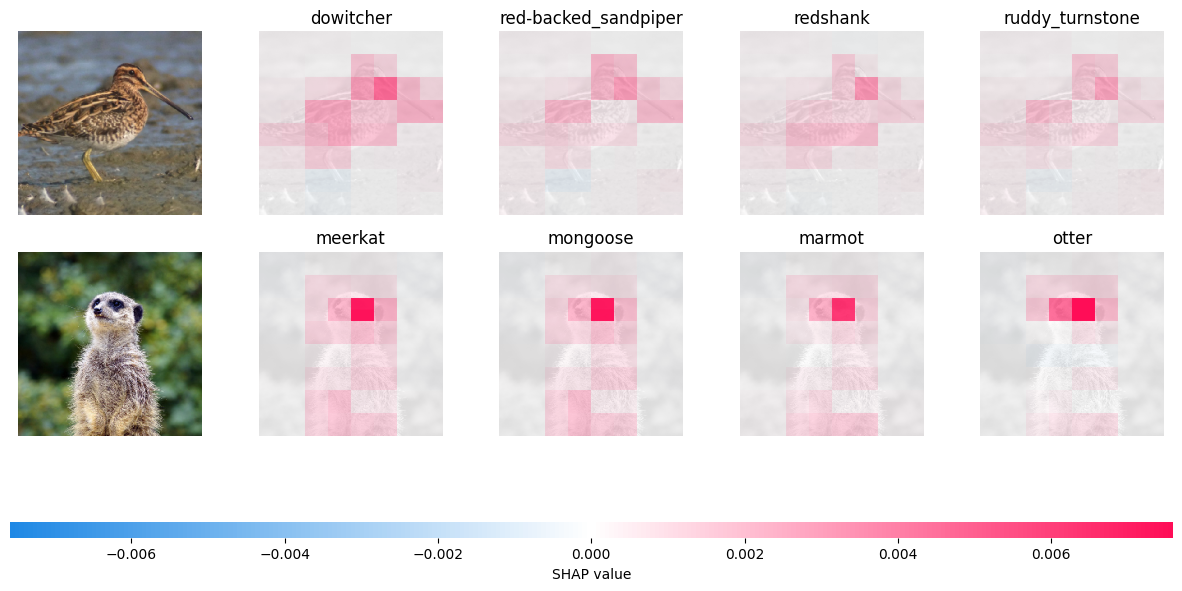

In [30]:
""" Shap Value 측정 및 시각화 (1) """

### Shap Value 측정을 위한 모델 함수 정의
def model_prediction(imgs):
    tmp = imgs.copy()
    tmp = normalize(imgs)
    tmp = tmp.to(device)
    return model(tmp)

### Shap Value 연산
masker = shap.maskers.Image("inpaint_telea", X[0].shape) ### Image Pixel 색깔을 바꿔주어 개별 픽셀 무시
explainer = shap.Explainer(model_prediction, masker, output_names=idx2label)
shap_values = explainer(test_imgs, max_evals=100, outputs=shap.Explanation.argsort.flip[:4]) ### 게임이론 연산을 max_evals만큼 수행 --> 클수록 작은 픽셀 영역으로 XAI 가능

### 시각화
shap.image_plot(shap_values, test_imgs/255.)

PartitionExplainer explainer: 3it [01:00, 30.47s/it]               


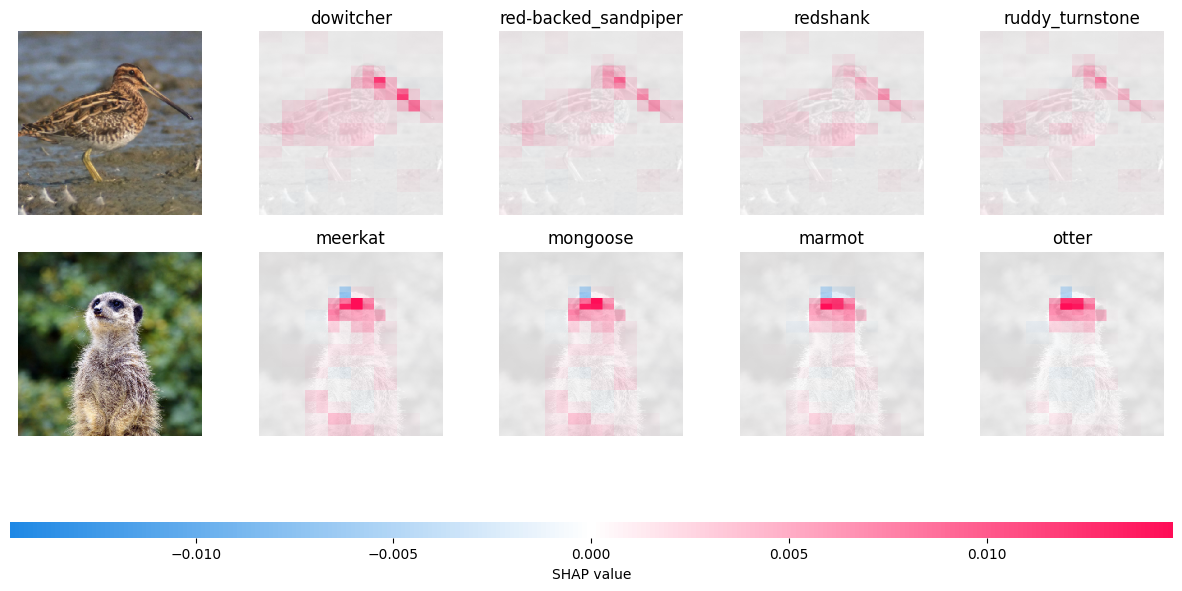

In [33]:
""" Shap Value 측정 및 시각화 (2) """

### Shap Value 연산
masker = shap.maskers.Image("blur(128,128)", X[0].shape) ### Image Pixel을 흐리게 하여 개별 픽셀 무시
explainer = shap.Explainer(model_prediction, masker, output_names=idx2label)
shap_values = explainer(test_imgs, max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

### 시각화
shap.image_plot(shap_values, test_imgs/255.)